<a href="https://colab.research.google.com/github/grkidwell/Integrated_magnetic/blob/master/48V_integratedmagnetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integrated Magnetic

### Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import Image, HTML, display

In [2]:
!rm -r time_based_waveforms
!git clone https://github.com/grkidwell/time_based_waveforms.git
sys.path.append('time_based_waveforms')

Cloning into 'time_based_waveforms'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 5), reused 7 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [29]:
!rm -r Integrated_magnetic
!git clone https://github.com/grkidwell/Integrated_magnetic.git
sys.path.append('Integrated_magnetic')

Cloning into 'Integrated_magnetic'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 75 (delta 1), reused 0 (delta 0), pack-reused 69
Unpacking objects: 100% (75/75), done.


In [0]:
from unit_waveforms import Four_state

###Classes

#### Core

In [0]:
class PQcore:   
#note: these calculations are more appropriate for EE core, than PQ core
#because PQ mean path length has diagonal element in x dimension

#does not capture Amin, which is usually 10% lower than Ae

    def __init__(self, core_geom, u, gaps):
        self.core_geometry = core_geom
        self.gap_lengths = gaps
        self.u = u
        self.area_cp2l_ratio=2
        
        self.leg_areas = {'left':self.core_geometry['Area']/self.area_cp2l_ratio,
                          'right':self.core_geometry['Area']/self.area_cp2l_ratio,
                          'center':self.core_geometry['Area']}
        
        self.segment_areas={
            'AB':self.leg_areas['left'],
            'BC':self.leg_areas['right'],
            'CD':self.leg_areas['right'], 
            'DE':self.leg_areas['right'],
            'EF':self.leg_areas['left'],
            'AF':self.leg_areas['left'],
            'BE':self.leg_areas['center']}
        
        self.segment_fluxpath_lengths={
            'AB':self.core_geometry['length']/2,
            'BC':self.core_geometry['length']/2,
            'CD':self.core_geometry['height'] - self.gap_lengths['CD'],
            'DE':self.core_geometry['length']/2,
            'EF':self.core_geometry['length']/2,
            'AF':self.core_geometry['height'] - self.gap_lengths['AF'],
            'BE':self.core_geometry['height'] - self.gap_lengths['BE']}

#### Winding

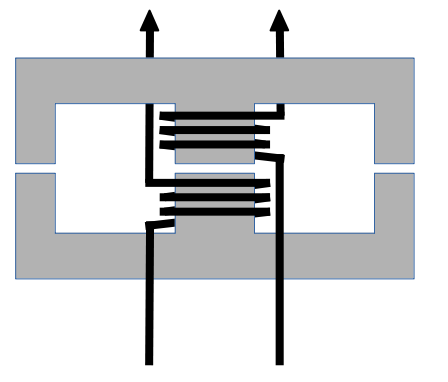

In [6]:
Image('Integrated_magnetic/autotransformer.PNG', width=400)


In [0]:
class Winding:
    def __init__(self, turns):
        self.turns=turns

#### Time States

In [0]:
class Time_states:  
  
#should be able to solve for time-states based on ac flux balance.
#can also try to play with asymmetrical time periods
  
    def __init__(self,fs,duty):
        self.fs = fs*2
        self.ts = 1/fs
        self.duty = duty
        self.four_states=self.calculate_4state(fs=self.fs,duty=self.duty)
        
    def calculate_4state(self,fs,duty):
        ts = 1/self.fs
        t1 = self.duty*ts
        t3 = t1
        t2 = (ts-t1-t3)/2
        t4 = t2
        return {'state1':t1,
                'state2':t2,
                'state3':t3,
                'state4':t4}

#### AC fluxes

In [9]:
#derived using gyrator-cap model.
display(HTML("<table><tr><td><img src='https://github.com/grkidwell/Integrated_magnetic/blob/master/series_windings_acfluxrates.PNG?raw=1' width=400 height=250></td><td><img src='https://github.com/grkidwell/Integrated_magnetic/blob/master/winding_voltage_by_state_3.PNG?raw=1' width=450 height=250></td><td><img src='https://github.com/grkidwell/Integrated_magnetic/blob/master/fluxrate_sources.PNG?raw=1' width=400 height=250></td></tr></table>"))


,,


$N_1\cdot\dot\Phi_1-N_{c1}\cdot\dot\Phi_c=V_{phase1}-V_{out}$ 

$-N_{c2}\cdot\dot\Phi_c+N_2\cdot\dot\Phi_2=V_{out}-V_{phase2}$ 

$\dot\Phi_1+\dot\Phi_c+\dot\Phi_2=0$



In [0]:
class AC_fluxes:   #only for Vout=<Vin/4
    
    def __init__(self, core, winding, vin, vout, fs, time_states):
      
        self.core=core
        
        self.winding=winding        
        self.fullturns1  = self.winding.turns['full1']
        self.fullturns2  = self.winding.turns['full2']
        self.halfturns1  = self.winding.turns['half_window1']   # number of half turns through window 1
        self.halfturns2  = self.winding.turns['half_window2']   # number of half turns through window 2
        
        self.vin = vin
        self.vout = vout
        
        self.time_states=time_states
        self.ts = sum(self.time_states.values())
        
        self.fluxrates=self.calculate_fluxrates()
        self.deltaflux = self.calculate_fluxchanges()
        
        self.fluxbalance=self.confirm_flux_balance()
        
        self.offset=self.calculate_offset()
        #self.fluxbalance=sum(self.deltaflux)
        
    def calculate_fluxrates(self):
        vphase1 = {'state1':self.vin/2,
                   'state2':0,
                   'state3':0,
                   'state4':0}
        vphase2 = {'state1':0,
                   'state2':0,
                   'state3':self.vin/2,
                   'state4':0}
        
        
        #3 equations, 3 unknowns to solve for flux rates.  
        #'up' = positive for all 3 legs
        coefficients = np.array([
                        [self.halfturns1, -self.fullturns1,               0],
                        [              0, -self.fullturns2, self.halfturns2],
                        [              1,             1,               1]])
        
        #winding_voltages = np.array([vphase1[self.state]-self.vout,
        #                             self.vout-vphase2[self.state],
        #                                                         0])
        legs = ['left','center','right']
        
        #create dictionary of dictionaries of fluxrates[state][leg]
        fluxratedict = {}
        for state in self.time_states:
            winding_voltages = np.array([vphase1[state]-self.vout,
                                         self.vout-vphase2[state],
                                                                0])
            fluxratedict[state]= dict(zip(legs,np.linalg.solve(coefficients,winding_voltages)))
        return  fluxratedict
    
    def calculate_fluxchanges(self):
        deltafluxdictofdicts={}  #[state][leg]
        for state, time in self.time_states.items():
            fluxrate_legs=self.fluxrates[state]
            deltafluxdictofdicts[state]={leg:time*fluxrate for leg,fluxrate in fluxrate_legs.items()}
        return deltafluxdictofdicts
      
    def confirm_flux_balance(self):
        deltafluxsum={'left':0,'center':0,'right':0}
        for state, leg_deltaflux in self.deltaflux.items():
            for leg, deltaflux in leg_deltaflux.items():
                deltafluxsum[leg]+=deltaflux
        return deltafluxsum
      
    def calculate_offset(self):
        offset={'left':0,'center':0,'right':0}
        for state, leg_deltaflux in self.deltaflux.items():
            for leg, deltaflux in leg_deltaflux.items():
                offset[leg]+=deltaflux*self.time_states[state]/2/self.ts
        return offset
        


#### Reluctance

In [0]:
class Reluctance_model:

  #valid for 3 leg EE/EI type core geometry (EE, EI, PQ, RM, etc.)
  
    def __init__(self,core):
      
        self.core=core
        
        #create dictionary of core segment reluctances
        self.segment_reluctances = {key: self.reluctance(ur=self.core.u, length=value, area=self.core.segment_areas[key])  for key, value in self.core.segment_fluxpath_lengths.items()}
    
        #add gap reluctances to legs
        for key, value in self.core.gap_lengths.items():
            self.segment_reluctances[key]+=self.reluctance(ur=1, length=value, area=self.core.segment_areas[key])
        
        #each leg is made up of segments
        self.leg_segments={
            'left':   ['AB','EF','AF'],
            'right':  ['BC','CD','DE'],
            'center': ['BE']
        }
        
        #create dictionary of leg reluctances
        self.leg_reluctances = {leg: self.total_reluctance(segmentlist) for leg, segmentlist in self.leg_segments.items()}
        
        #create dictionary of reluctances seen by each winding
        self.winding_reluctances = {'half_window1': self.leg_reluctances['left']  + self.parallel(self.leg_reluctances['center'],self.leg_reluctances['right']),
                                    'half_window2': self.leg_reluctances['right'] + self.parallel(self.leg_reluctances['center'],self.leg_reluctances['left']),
                                    'full'        : self.leg_reluctances['center']+ self.parallel(self.leg_reluctances['left'],self.leg_reluctances['right'])}
    
        #create dictionary of parallel reluctances.  Used in superposition calculation
        self.parallel_reluctances = {'Rpc2': self.parallel(self.leg_reluctances['center'],self.leg_reluctances['right']),
                                     'Rpc1': self.parallel(self.leg_reluctances['center'],self.leg_reluctances['left']),
                                     'Rp12': self.parallel(self.leg_reluctances['left'],  self.leg_reluctances['right'])}
        
        
        
    def reluctance(self,ur,length,area): 
        uo = 4*np.pi*1e-7
        return length/(uo*ur*area)
      
    def total_reluctance(self,segmentlist):
        reluctance_list = [self.segment_reluctances[segment] for segment in segmentlist]
        return sum(reluctance_list)
    
    def parallel(self,a,b):
        return a*b/(a+b)
      


#### DC fluxes and currents

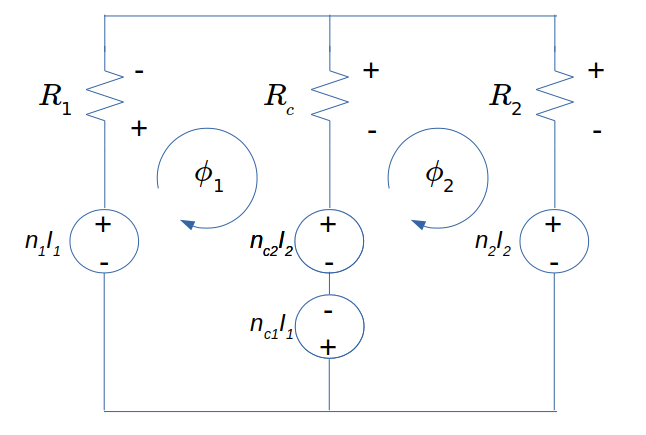

In [30]:
Image('Integrated_magnetic/DC_reluctance_circuit.PNG', width=400)

$R_{pc1}=\dfrac{R_cR_1}{R_c+R_1}\quad R_{pc2}=\dfrac{R_cR_2}{R_c+R_2}\quad R_{p12}=\dfrac{R_1R_2}{R_1+R_2}$ 
\
\
\
$n_1I_1+n_2I_2-R1\Phi_1-R_2\Phi_2=0$

$n_1I_1+n_2I_2=Iout$

$n_{c1}I_1-n_{c2}I_2=0$

$(\dfrac{n_1R_{pc2}}{R_1+R_{pc2}}-\dfrac{n_{c1}R_{p12}}{R_c+R_{p12}}-n_1)I_1+$
$(\dfrac{n_{c2}R_{p12}}{R_c+R_{p12}}-\dfrac{n_2R_{pc1}}{R_2+R_{pc1}})I_2+R_1\Phi_1=0$

In [0]:
class DC_fluxes_and_currents:
  
    def __init__(self, core, winding, iout):  #warning: an imbalance in leg currents could produce DC flux in the magnetizing 
        self.core=core               
        self.winding=winding
        self.iout = iout
        self.reluctances=Reluctance_model(self.core)
        
        self.dc_fluxes_and_currents=self.calculate_dc_fluxes_and_currents()
        self.dc_fluxes = self.dc_fluxes_and_currents['dc_flux_per_leg']
        self.dc_currents = self.dc_fluxes_and_currents['amps_per_winding']
        
    def calculate_dc_fluxes_and_currents(self):
        nc1=self.winding.turns['full1']
        nc2=self.winding.turns['full2']
        n1=self.winding.turns['half_window1']
        n2=self.winding.turns['half_window2']
        
        r1=self.reluctances.leg_reluctances['left']
        r2=self.reluctances.leg_reluctances['right']
        rc=self.reluctances.leg_reluctances['center']
        
        rpc1=self.reluctances.parallel_reluctances['Rpc1']
        rpc2=self.reluctances.parallel_reluctances['Rpc2']
        rp12=self.reluctances.parallel_reluctances['Rp12']
        
        
        coefficients = np.array([
            [n1, n2, -r1, -r2],
            [n1, n2,   0,   0],
            [nc1,-nc2,  0,  0],
            [n1*rpc2/(r1+rpc2)-rp12*nc1/(rc+rp12)-n1, rp12*nc2/(rc+rp12)-rpc1*n2/(r2+rpc1), r1, 0]])
        
        const_array = np.array([        0,
                                self.iout,
                                        0,
                                        0])
        
        #solve for [I1,I2,flux1,flux2]
        solution = np.linalg.solve(coefficients,const_array)
        
        #half_window1 winding is in series with full1 winding, so both are I1
        #half_window2 winding is in series with full2 winding, so both are I2
        amps_per_winding = {'half_window1':solution[0], 'full1':solution[0],
                            'half_window2':solution[1], 'full2':solution[1]}
        
        #'up' = positive for all 3 legs
        dc_flux_per_leg = {'left':solution[2],'right':-solution[3],'center':-(solution[2]-solution[3])}
        
        return {'amps_per_winding':amps_per_winding, 'dc_flux_per_leg':dc_flux_per_leg}


#### Permeance

In [0]:
class Permeance_model:
  
    def __init__(self,core):
        self.core = core
        self.reluctances = Reluctance_model(core)
        
        self.leg_permeances = self.permeance_dicts(self.reluctances.leg_reluctances)
        
    def permeance(self,r):
        return 1/r
    
    def permeance_dicts(self,r):
        return {key: 1/value for key, value in r.items()}
      



#### Flux Densities

In [0]:
class Flux_densities:
  
    def __init__(self,acfluxes,dcfluxes):
      
        self.acfluxes=acfluxes
        self.leg_areas=self.acfluxes.core.leg_areas
        self.time_states=self.acfluxes.time_states
        
        self.deltaflux=self.acfluxes.deltaflux
        self.bac = self.calculate_bac()
        self.bac_offset=self.acfluxes.offset
      
        self.dcfluxes = dcfluxes
        self.bdc = self.calculate_bdc()
        self.bacdc = self.calculate_bacdc()
        
    def calculate_bac(self):
        deltaflux=self.acfluxes.deltaflux
        bpp_dictofdicts={} 
        for state, time in self.time_states.items():
            deltaflux_legs=self.deltaflux[state]
            bpp_dictofdicts[state]={leg:delta_flux/self.leg_areas[leg] for leg, delta_flux in deltaflux_legs.items()}
        return bpp_dictofdicts
      
    def calculate_bdc(self):
        bdc = {leg: flux/self.leg_areas[leg] for leg, flux in self.dcfluxes.items()}
        return bdc
        
    def calculate_bacdc(self):
        bacdc={}
        for state, leg_bac in self.bac.items():
            bacdc[state] = {leg: self.bdc[leg]+bac/2-self.bac_offset[leg]*0 for leg, bac in leg_bac.items()}
        return bacdc
        

#### DC+AC Winding currents

In [0]:
class Winding_currents:
    pass

#### AC currents

In [0]:
class AC_currents:
    
    def __init__(self,acfluxes):
        
        self.acfluxes=acfluxes
        
        self.core=self.acfluxes.core
        self.permeances=Permeance_model(self.core).leg_permeances
        
        self.time_states=self.acfluxes.time_states
        self.fluxrates=self.acfluxes.fluxrates
        self.turns=self.acfluxes.winding.turns
        
        self.deltaflux=self.acfluxes.deltaflux #calculate_fluxchanges()
        
        self.deltaMMF=self.calculate_deltaMMFs()
        
        self.ac_currents = self.calculate_ac_currents()
        
    def calculate_deltaMMFs(self):
        p1 = self.permeances['left']
        pc = self.permeances['center']
        p2 = self.permeances['right']
      
        coefficients = np.array([
            [1,                     -1,         0],
            [0,                     1,         -1],
            [p1/(pc+p2)-1, pc/(p1+p2), p2/(p1+pc)]])
        
        legs = ['left','center','right']
        #create dictionary of dictionaries of deltaMMFs[state][leg]
        deltaMMFdictofdict={}
        for state in self.time_states:
            right_matrix = np.array([ self.deltaflux[state]['left']/p1  - self.deltaflux[state]['center']/pc,
                                     -self.deltaflux[state]['right']/p2 + self.deltaflux[state]['center']/pc,
                                     -self.deltaflux[state]['left']/p1])
            deltaMMFdictofdict[state]=dict(zip(legs,np.linalg.solve(coefficients,right_matrix)))
        return deltaMMFdictofdict
      
    def calculate_ac_currents(self):
        ac_rippledictofdict={}
        for state in self.time_states:
            ac_rippledictofdict[state]={'half_window1':self.deltaMMF[state]['left']/self.turns['half_window1'],
                                        'half_window2':self.deltaMMF[state]['right']/self.turns['half_window2'],
                                        'full1':self.deltaMMF[state]['center']/(self.turns['full1']),
                                        'full2':self.deltaMMF[state]['center']/(self.turns['full2'])}
        return ac_rippledictofdict
        

###Input Parameters

In [0]:
Vin = 60
Vout = 12
iout = 25

fs=200e3

duty=Vout/(Vin/2)

time_states=Time_states(fs=fs,duty=duty).four_states

#length, height  at core center (mean flux path).  Area is at center post
PQ2620 = {'length':22.5e-3, 'height':11.5e-3, 'Area':119e-6}  
PQ2020 = {'length':18.5e-3, 'height':11.5e-3, 'Area':62e-6}  
PQ1612 = {'length':12e-3, 'height':9e-3, 'Area':42e-6}  

gap_lengths = {'AF':0.1e-3, 'BE':0.1e-3, 'CD':0.1e-3}

pqintcore=PQcore(PQ1612,3200,gap_lengths)

nturns = {'half_window1':1, 'full1':3, 'full2':3, 'half_window2':1}
wind3p5turn=Winding(nturns)

###Results

In [23]:
dc_fluxes_and_currents=DC_fluxes_and_currents(core=pqintcore, winding=wind3p5turn,iout=iout)
ac_fluxes=AC_fluxes(core=pqintcore, winding=wind3p5turn, vin=Vin, vout=Vout, fs=fs, time_states=time_states)
ac_fluxes.fluxbalance

{'center': 0.0, 'left': 2.541098841762901e-21, 'right': -2.964615315390051e-21}

In [24]:
ac_currents=AC_currents(ac_fluxes).ac_currents
ac_currents

{'state1': {'full1': -1.3171599002809868,
  'full2': -1.3171599002809868,
  'half_window1': 25.155706048995924,
  'half_window2': 0.934313147198101},
 'state2': {'full1': -5.921189464667501e-16,
  'full2': -5.921189464667501e-16,
  'half_window1': -12.11069645089891,
  'half_window2': 12.110696450898907},
 'state3': {'full1': 1.3171599002809866,
  'full2': 1.3171599002809866,
  'half_window1': -0.9343131471981003,
  'half_window2': -25.15570604899593},
 'state4': {'full1': -5.921189464667501e-16,
  'full2': -5.921189464667501e-16,
  'half_window1': -12.11069645089891,
  'half_window2': 12.110696450898907}}

In [27]:

b=Flux_densities(ac_fluxes,dc_fluxes_and_currents.dc_fluxes)
b.bacdc

{'state1': {'center': -0.051020408163265356,
  'left': 0.2698983267829095,
  'right': -0.16785751045637878},
 'state2': {'center': -4.033490225020478e-17,
  'left': 0.07602077576250134,
  'right': -0.07602077576250126},
 'state3': {'center': 0.05102040816326527,
  'left': 0.1678575104563789,
  'right': -0.2698983267829094},
 'state4': {'center': -4.033490225020478e-17,
  'left': 0.07602077576250134,
  'right': -0.07602077576250126}}

In [0]:
def ac_current_function(t):
    pass
    